# **MSCI 332 Tutorial 2**

[Colab link](https://colab.research.google.com/drive/1usoAJ6cccIaw8LYBrOYnupLP0Mmz1kud?usp=sharing)

In [1]:
!pip install gurobipy>=9.5.1
import gurobipy as gp
from gurobipy import GRB as GRB
import numpy as np

## **Facility Location Problem**

The capacitated facility location problem (FLP) is a classical problem in location theory. It has applications in strategic supply chain design and production-distribution systems planning. It concerns locating facilities with limited capacity to serve customers.

Given a set of customers $I$ each with demand $d_i$ $(\forall i \in I)$ and a set of potential facility locations $J$, each with capacity $L_j$, and fixed location cost $F_j$ $(\forall j \in J)$, transportation costs $c_{ij}$ to transport one unit of demand from facility in location $j$ to customer $i$, $(\forall i \in I, j \in J)$, FLP locates facilities and assigns customers so that the total location and transportation costs are minimized while the capacity limit is not exceeded. Assume that customer demand can be satisfied from multiple facilities.

### **Mathematical Model**

#### Sets
- I: Set of customers
- J: Set of candidate facility locations

#### Parameters
- $d_i$: demand of customer $i$
- $L_j$: capacity of candidate facility $j$
- $F_j$: fixed cost of opening facility $j$
- $c_{ij}$: unit transportation cost from facility $j$ to customer $i$

#### Decision Variables
- $y_j$: $\begin{cases}1 & \text{ if candidate facility }j\text{ is opened}\\0& \text{ otherwise}\end{cases}$
- $x_{ij}$: amount of supply transported from facility $j$ to customer $i$

#### Formulation

$$
\begin{align}
\min \quad&\sum_{i\in I}\sum_{j\in J}c_{ij} x_{ij} + \sum_{j\in J} F_j y_j &\\
\text{s.t.} \quad&\sum_{j\in J} x_{ij} = d_i &\forall i\in I\\
& \sum_{i\in I} x_{ij} \leq L_j y_j & \forall i \in I\\
& 0 \leq x_{ij} \quad y_{j} \in \{0, 1\} & \forall i\in I, j\in J
\end{align}
$$

#### Random instance generator:

In [4]:
# set random seed
np.random.seed(332)

# customer and facility sets
I = range(15)
J = range(10)

# randomize parameters
c = np.random.uniform(0.5, 10, size=(len(I), len(J)))
F = np.random.uniform(300, 500, size=len(J))
d = np.random.uniform(40, 100, size=len(I))
L = np.random.uniform(200, 500, size=len(J))

#### Mathematical model implementation:

In [19]:
# model instance
model = gp.Model(name="FacilityLocationProblem")

# variables
x = model.addVars(I, J, lb=0.0, vtype=GRB.CONTINUOUS, name="x")
y = model.addVars(J, vtype=GRB.BINARY, name="y")

# constraints
# first constraint, using add constrs
model.addConstrs(sum(x[i, j] for j in J) == d[i] for i in I)
# second constraint, using one line for loop
[model.addConstr(sum(x[i, j] for i in I) <= L[j] * y[j]) for j in J]

# objective
model.setObjective(
    sum(c[i, j] * x[i, j] for j in J for i in I) + sum(F[j] * y[j] for j in J),
    sense=GRB.MINIMIZE
)

# optimize
model.optimize()

# output
print(f"\nOptimal plan cost: {model.getObjective().getValue(): .2f}")
for j in J:
  if y[j].X:  # if y_j is non-zero
    print()
    print(f"Facility {j} is open (cost: {F[j]: .2f})")
    for i in I:
      if x[i, j].X:  # if x_ij is non-zero
        print(f"{x[i, j].X: .2f} units are served to customer {i} "
              f"(cost:{c[i, j] * x[i, j].X: 3.2f}). Which is"
              f"{x[i, j].X / d[i] * 100: .2f}% of customer's total demand and"
              f"{x[i, j].X / L[j] * 100: .2f}% of facility supply.")

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Optimize a model with 25 rows, 160 columns and 310 nonzeros
Model fingerprint: 0x35426733
Variable types: 150 continuous, 10 integer (10 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+02]
  Objective range  [5e-01, 5e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+01, 1e+02]
Presolve time: 0.00s
Presolved: 25 rows, 160 columns, 310 nonzeros
Variable types: 150 continuous, 10 integer (10 binary)
Found heuristic solution: objective 4505.0111952

Root relaxation: objective 2.495907e+03, 17 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 2495.90719    0    8 4505.01120 2495.90719  44.6%     -    0s
H    0     0                    4425.2527845 2495.90719  43.6%     -    0s
 

## **Multicommodity Network Flow Problem**

Suppose that a logistics company delivers a number of different commodities from manufacturing plants to factories. For each manufacturing plant, company has to decide on a set of routes to be used to deliver its goods. Each route has an associated unit transportation cost and capacity with it. An example problem layout is provided below.

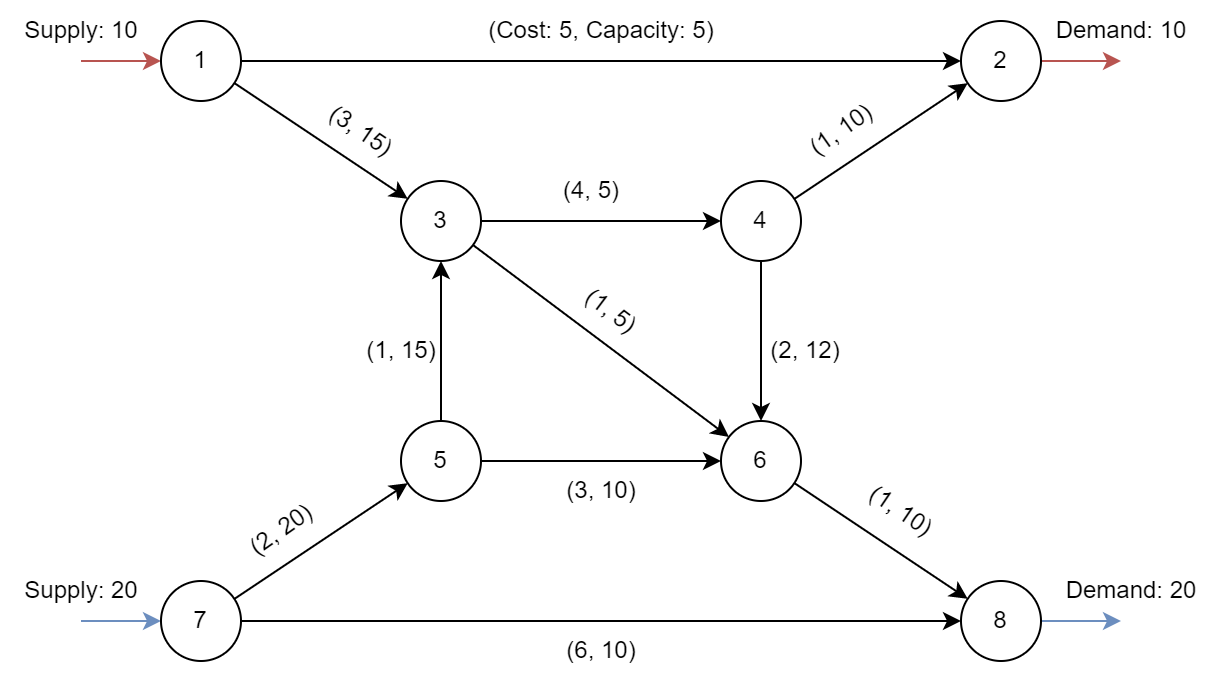

### **Mathematical Model**

Let $N$ and $A$ be the set of nodes and arcs in the layout, $c_{ij}^k$ be the cost of transporting a unit of $k$ from node $i$ to $j$, $u_{ij}$ be the capacity of arc $(i,j)$ and $b_i^k$ be the demand of node $i$ for commodity $k$. Let $x_{ij}^k$ be the amount of commodity $k$ transported from node $i$ to $j$, then we have the following mathematical formulation:

$$
\begin{align}
\min \quad & \sum_{(i, j)\in A}\sum_{k\in K} c^k_{ij} x^k_{ij}&\\
\text{s.t.} \quad & \sum_{k\in K} x^k_{ij} \leq u_{ij} & \forall (i, j)\in A\\
& \sum_{(i, j)\in A}x^k_{ij} - \sum_{(j, i)\in A} x^k_{ji} = b^k_i & \forall i\in N, k\in K\\
& x^k_{ij} \geq 0 & \forall (i,j)\in A, k\in K
\end{align}
$$

Node $i$ is called a source node if $b_i^k > 0$ (has a supply), and a sink node if $b_i < 0$ (has a demand; negative supply). All other nodes have $b_i^k = 0$.

### **Random Instance Generator**


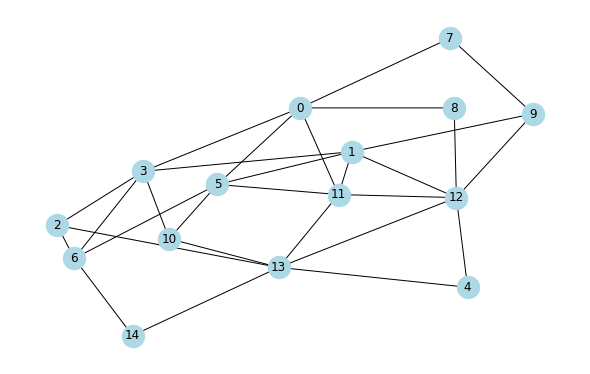

In [ ]:
from itertools import combinations, groupby
import networkx as nx
import random
import matplotlib.pyplot as plt

np.random.seed(332444)
K = 3

# original version from https://stackoverflow.com/a/61961881
def gnp_random_connected_graph(n, p):
    """
    Generates a random undirected graph, similarly to an Erdős-Rényi 
    graph, but enforcing that the resulting graph is conneted
    """
    edges = combinations(range(n), 2)
    G = nx.Graph()
    G.add_nodes_from(range(n))
    if p <= 0:
        return G
    if p >= 1:
        return nx.complete_graph(n, create_using=G)
    for _, node_edges in groupby(edges, key=lambda x: x[0]):
        node_edges = list(node_edges)
        index = np.random.randint(len(node_edges))
        random_edge = node_edges[index]
        G.add_edge(*random_edge)
        for e in node_edges:
            if np.random.random() < p:
                G.add_edge(*e)
    return G

nodes = 5 * K
probability = 0.2
G = gnp_random_connected_graph(nodes, probability)

# visualizing the graph
plt.figure(figsize=(8,5))
nx.draw(G, node_color='lightblue', 
        with_labels=True, 
        node_size=500)

In [ ]:
np.random.seed(3325555)

# extracting nodes and arcs from the constructed graph
N = list(G.nodes)
A = list(G.edges)
A += [(j, i) for (i, j) in A]

# selecting source and sink nodes at random
selected_nodes = np.random.choice(N, size=2*K, replace=False)
source_nodes = selected_nodes[:K]
sink_nodes = selected_nodes[K:]

# randomizing problem parameters
c = np.random.uniform(low=0.5, high=5, size=(len(A), K))  # unit flow costs [arc, k]
u = np.random.uniform(low=100, high=150, size=(len(A)))  # arc capacities [arc]
b = np.zeros((len(N), K))  # supply requirements [node]
b[source_nodes, range(K)] = np.random.uniform(low=50, high=100, size=K)
b[sink_nodes] = -1 * b[source_nodes]

# printing some problem information
print("Source nodes:")
[print(f"{source_node}: has {b[source_node, k]: .2f} units of commodity {k}")
for k, source_node in enumerate(source_nodes)]
print("Sink nodes:")
[print(f"{sink_node}: demands {-b[sink_node, k]: .2f} units of commodity {k}")
for k, sink_node in enumerate(sink_nodes)]
print()  # to clear last result

Source nodes:
14: has  84.24 units of commodity 0
11: has  91.76 units of commodity 1
1: has  69.22 units of commodity 2
Sink nodes:
9: demands  84.24 units of commodity 0
8: demands  91.76 units of commodity 1
4: demands  69.22 units of commodity 2



In [ ]:
# model implementation
model = gp.Model("Multicommodity Network Flow")

# defining x manually since edge structure is abstract
x = dict()
for k in range(K):
  # enumerate(A) provides (element_index, element), so we use it to access related
  # cost value in c
  for arc_id, (i, j) in enumerate(A):
    # we can use obj attribute to avoid setting objective separately
    x[k, i, j] = model.addVar(lb=0, obj=c[arc_id, k], name=f"x[{k},{i},{j}]")

# capacity constraints
for arc_id, (i, j) in enumerate(A):
  model.addConstr(sum(x[k, i, j] for k in range(K)) <= u[arc_id], name=f"Cap[{k},{i},{j}]")

# supply constraints
for k in range(K):
  for i in N:
    model.addConstr(
        sum(x[k, i, j] for i2, j in A if i2 == i) - 
        sum(x[k, j, i] for j, i2 in A if i2 == i) == b[i, k],
        name=f"Sup[{k}{i}]"
    )

# optimize
model.optimize()

# output
for k in range(K):
  print()
  print("*" * 10, f"Commodity {k}", "*" * 10)
  for (i, j) in A:
    if x[k, i, j].X > 0:
      print(f"Arc [{i: <2}{' (source)' if i == source_nodes[k] else '': <9}, "
            f"{j: <2}{' (sink)' if j == sink_nodes[k] else '': <7}] carries "
            f"{x[k, i, j].X: .2f} units of commodity {k}")

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Optimize a model with 103 rows, 174 columns and 522 nonzeros
Model fingerprint: 0x0cd476e2
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e-01, 5e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e+01, 1e+02]
Presolve removed 14 rows and 18 columns
Presolve time: 0.03s
Presolved: 89 rows, 156 columns, 446 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   6.130402e+01   0.000000e+00      0s
      16    1.3178759e+03   0.000000e+00   0.000000e+00      0s

Solved in 16 iterations and 0.04 seconds (0.00 work units)
Optimal objective  1.317875941e+03

********** Commodity 0 **********
Arc [1          , 9  (sink)] carries  84.24 units of commodity 0
Arc [12         , 1        ] carries  84.24 units of commodity 0
Arc [13         , 12       ] carries  84.24 units of com

## **Stopping Rules**

Most of the realistic problems have large models that can't be solved in a reasonable time. In these cases, it's usually more preferable to have solver work on the problem for a while and return the best known solution, which can be achieved by setting up related model parameters by using `model.setParam(parameter_name, parameter_value)`:
- `TimeLimit`, set the time limit (in seconds) for solver. In a terminated model output, `model_variable.X` returns the value of a variable in the best solution seen so far.
- `MIPGap`, set the mixed integer problem tolerance limit (fraction) so that algorithm terminates when objective bounds are within tolerance ($\frac{UB - LB}{LB} \leq \text{limit}$).

Stopping conditions are applied individually, e.g. applying both conditions by `model.setParam("TimeLimit", 3600); model.setParam("MIPGap", 0.05)` results in model to terminate whenever one of the conditions is satisfied. Finding an optimal solution always terminates the algorithm.